# Energy Consumption Forecast
#### GitHub: https://github.com/ht314/uk-energy-consumption

This notebook will forecast daily UK Energy Consumption for 12 months using an LSTM architecture. 

## Setup

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

## The Energy Dataset

This notebook uses the energy dataset. 

This dataset contains a univariate feature, collected daily beginning in 2015.

In [3]:
# Download the energy.dat dataset and add the path to the read_csv file below
def parser(x):
    return datetime.strptime(x,'%d-%b-%y')

path = 'C:/Users/ht314/Desktop/energy.dat'
df = pd.read_csv(path, header=0, index_col=0, date_parser=parser)

In [4]:
# Let's take a glance at the data. Here are a few rows: 
df.head()

,Consumption
Date,
2015-04-01,357.073
2015-04-02,341.931
2015-04-03,318.777
2015-04-04,312.494
2015-04-05,270.837


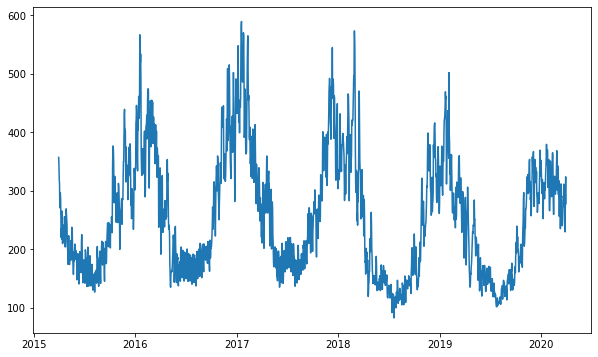

In [5]:
# Here is the evolution of the feature over time 
plt.plot(df)

In [6]:
# Next let's look at the statistics of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Consumption,1827.0,257.885096,100.993368,82.675,174.6725,242.719,327.841,589.269


## Feature Engineering

### Frequency Feature

We want to give the model access to the most important frequency features. As we do not know ahead of time which 
frequencies are important, we can determine this using a Fast Fourier Transform (fft). We have an assumption that the 
dataset will display yearly, weekly and weekend periodicity. 

To check our assumptions we check the tf.signal.rfft of the signal over time and note the peak frequencies.

Text(0.5, 0, 'Frequency (log scale)')

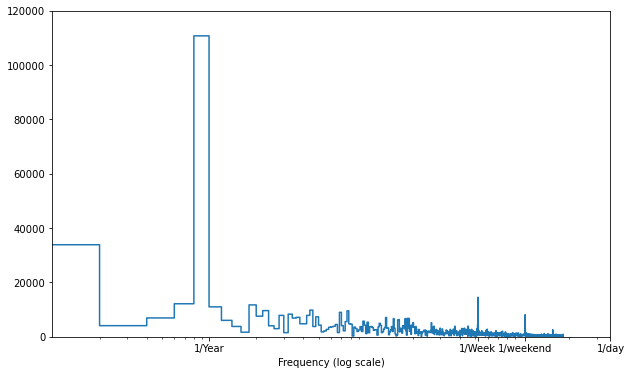

In [7]:
fft = tf.signal.rfft(df['Consumption'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Consumption'])
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/(years_per_dataset)
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 120000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 52, 104, 365.2524], labels=['1/Year', '1/Week', '1/weekend', '1/day'])
plt.xlabel('Frequency (log scale)')

### Time
The 'Date' column is useful. Let's start by converting it to seconds: 

In [8]:
# Prepare the data for 12 months forecasting (2020-3-31 to 2021-3-31)
ix = pd.date_range(start=datetime(2015, 4, 1), end=datetime(2021, 3, 31), freq='D')
df = df.reindex(ix)
df.index.names = ['Date']
df = df.reset_index()

# Convert to seconds
date_time = pd.to_datetime(df.pop('Date'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.timestamp)

The frequency analysis performed above confirms the data has weekly and yearly periodicity. One approach to 
convert this to a usable signal is to use sin and cos to convert the time to 'Time of week' and 'Time of year' signals: 

Text(0.5, 1.0, 'Time of Week signal')

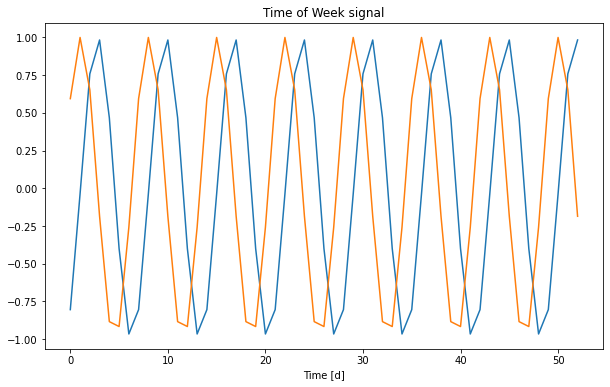

In [9]:
day = 24*60*60
week = 7*24*60*60
year = (365.2425)*day

df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Week sin'])[:53])
plt.plot(np.array(df['Week cos'])[:53])
plt.xlabel('Time [d]')
plt.title('Time of Week signal')

Text(0.5, 1.0, 'Time of year signal')

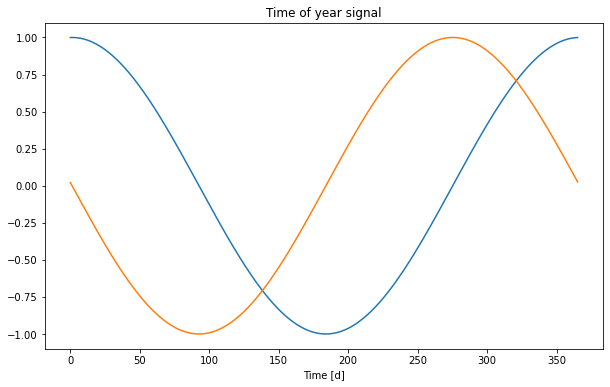

In [10]:
plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(df['Year cos'])[:366])
plt.xlabel('Time [d]')
plt.title('Time of year signal')

In [10]:
print(df)

      Consumption  Week sin  Week cos  Year sin  Year cos
0         357.073 -0.804598  0.593820  0.999763  0.021756
1         341.931 -0.037391  0.999301  0.999990  0.004555
2         318.777  0.757972  0.652287  0.999920 -0.012647
3         312.494  0.982566 -0.185912  0.999555 -0.029846
4         270.837  0.467269 -0.884115  0.998893 -0.047036
...           ...       ...       ...       ...       ...
2187          NaN  0.974928 -0.222521  0.995233  0.097524
2188          NaN  0.433884 -0.900969  0.996763  0.080390
2189          NaN -0.399892 -0.916562  0.997953  0.063947
2190          NaN -0.965926 -0.258819  0.998906  0.046771
2191          NaN -0.804598  0.593820  0.999562  0.029581

[2192 rows x 5 columns]


### Data windowing

In [11]:
def split_multivariate_multistep_sequence(
    sequences, n_steps_in, n_steps_out): 
    # split a multivariate sequence into samples
    X, y = list(), list()
    for i in range(len(sequences)): 
        # find the end of this pattern 
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences): 
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[
                end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
def build_model():
    """Build LSTM Model
    
    This function will build a four layered LSTM. The last layer is a Dense 
    Layer. The second and third layers are LSTM layers.
    """
    
    n_features = train_dataset.shape[1]-1
    model = keras.Sequential([
        layers.LSTM(64, activation=tf.nn.relu, return_sequences=True,
                    input_shape=(n_steps_in, n_features)), 
        layers.LSTM(64, activation=tf.nn.relu, return_sequences=True),
        layers.LSTM(32, activation=tf.nn.relu),
        layers.Dense(n_steps_out)
    ])
    
    # Optimisation
    # Adam is a method for the optimisation of stochastic objective function. 
    # The idea is to estimate the first two moments with exponentially decaying 
    # running averages. Additionally, these estimates are bias corrected which 
    # improves over the initial learning steps since both estimates are initialised 
    # with zeros. 
    
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001, # determines the step size at each iteration of the SGD algorithm
        beta_1=0.9, # Exponential decay rate for the 1st moment estimates. Defaults to 0.9
        beta_2=0.999, # Exponential decay rate for the 2nd moment estimates. Defaults to 0.999
        epsilon=1.0, # A small constant for numerical stability. Defaults to 1e-7.
        amsgrad=False # Whether to apply AMSGrad variant of this algorithm. 
    )
    
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=[
            'mean_absolute_error', 
            'mean_squared_error'
        ])
    
    return model


def fit_model():
    """Fit Model
    
    This function will set the patiance parameter; the amount of epochs to check
    for improvement. It will also fit the model. 
    """
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_mean_absolute_error', patience=5000)
    EPOCHS = 500
    VLDTN = int(len(X)*0.90)
    history = model.fit(
            X[:VLDTN], y[:VLDTN],
            epochs=EPOCHS, 
            batch_size=4,
            validation_data = (X[VLDTN:], y[VLDTN:]), 
            verbose=1,
            callbacks=[#cp_callback, 
                       early_stop, 
                       PrintDot()])    
    
    return history


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
      
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Consumption WS]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    #plt.ylim([0, 10])
    plt.legend()
      
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Consumption_WS^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    #plt.ylim([0, 100])
    plt.legend()
    plt.show()


def make_predictions(model):
    test_predictions = model.predict(X).flatten()
    plt.figure()
    plt.scatter(y, test_predictions)
    plt.plot(np.linspace(67, 200, 100), np.linspace(67, 200, 100), 'k-', 
             linewidth=0.7)
    plt.xlabel('True Values [Consumption]')
    plt.ylabel('Predictions [Consumption]')
    plt.axis('equal')
    plt.axis('square')
    #plt.xlim([0,plt.xlim()[1]])
    #plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot()#[-20, 70], [-20, 70])
    plt.figure()
    error = test_predictions - y
    plt.hist(error, bins=15)
    plt.xlabel("Prediction Error [Consumption]")
    _ = plt.ylabel("Count")


def make_forecast(raw_data):
    """Forecast
    
    This function will forecast prices using the trained model. 
    """
    
    #forecast_data = raw_dataset
    #forecast_data = forecast_data[forecast_data.index > '2019-07-31']
    start_date = raw_data['Consumption'].dropna().index[-1]
    forecast_data = raw_data.loc[start_date:]
    '''
    #normed_train_data = norm(forecast_data.iloc[:,:-1], train_stats)
    normed_forecast_data = concat([
        normed_train_data, forecast_data.iloc[:,-1]], axis=1)
    '''
    X, y = split_multivariate_multistep_sequence(
        forecast_data.values, n_steps_in, n_steps_out)
    
    forecast_values = model.predict(X).flatten()
    forecast =pd.DataFrame(
        forecast_values, index=forecast_data.index[0:len(forecast_values)],
        columns=['Consumption-F'])

    forecast.index = forecast.index.strftime('%Y-%m-%d')
    print(forecast)
 
    return forecast

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 63,137
Trainable params: 63,137
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
349/349 [==============================] - 4s 12ms/step - loss: 33140.3711 - mean_absolute_error: 128.7496 - mean_squared_error: 33140.3711 - val_loss: 3127.8286 - val_mean_absolute_error: 42.7533 - val_mean_squared_error: 3127.8286


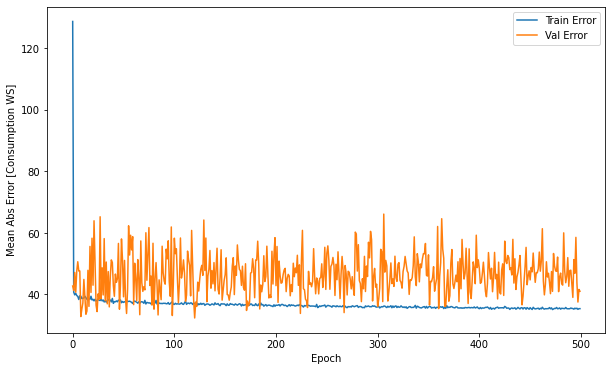

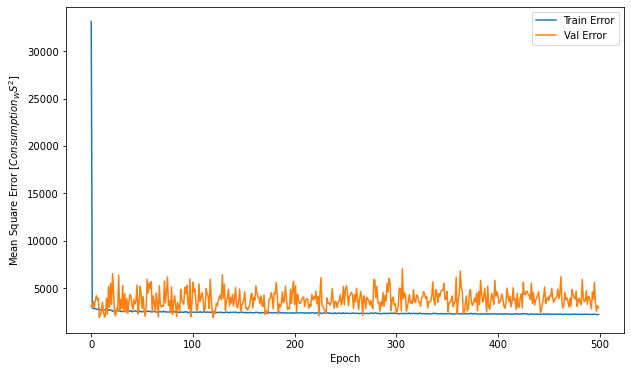

In [13]:
df.index = ix
df = df[['Week sin',  'Week cos',  'Year sin',  'Year cos', 'Consumption']]
 
# Build historical data
df1 = df.dropna()
    
# Preprocess LSTM Feed 
# This section will split the data into train and test datasets
    
n_steps_in, n_steps_out = 4, 1
train_dataset = df1.iloc[:int(len(df1) * 0.85), :]
test_dataset = df1.iloc[int(len(df1) * 0.85):, :]

# Build LSTM Model
model = build_model()
print(model.summary())

# Convert into input/output
    
X, y = split_multivariate_multistep_sequence(
            train_dataset.values, n_steps_in, n_steps_out) 

# Fit model
history = fit_model()    
plot_history(history) 


Testing set Mean Abs Error: 51.63 Consumption
            Consumption-F
Date                     
2020-03-31     266.362793
2020-04-01     233.873520
2020-04-02     218.453751
2020-04-03     245.314011
2020-04-04     243.668488
...                   ...
2021-03-24     252.267960
2021-03-25     242.504196
2021-03-26     284.382080
2021-03-27     283.861755
2021-03-28     285.557770

[363 rows x 1 columns]


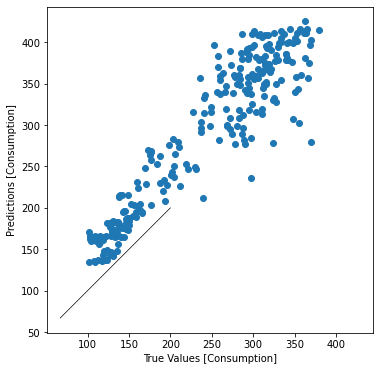

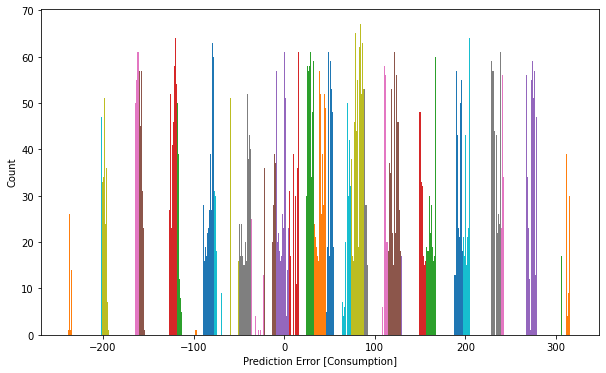

In [14]:
X, y = split_multivariate_multistep_sequence(
        test_dataset.values, n_steps_in, n_steps_out)
    
loss, mae, mse = model.evaluate(X, y, verbose=0)
print("\nTesting set Mean Abs Error: {:5.2f} Consumption".format(mae))
make_predictions(model)
cnsmptn_frcst = make_forecast(df)
cnsmptn_frcst.index = pd.to_datetime(cnsmptn_frcst.index)

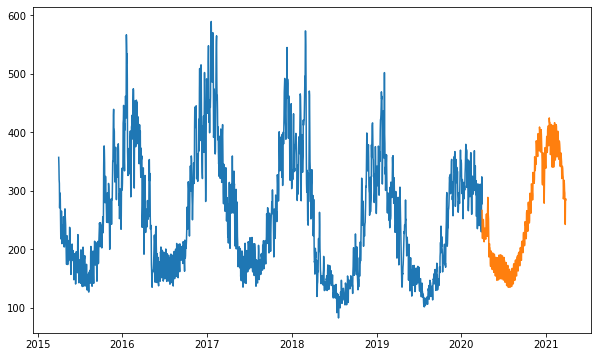

In [15]:
plt.plot(df1['Consumption'])
plt.plot(cnsmptn_frcst)